In [1]:
from ddganAE.models import AAE, AAE_combined_loss, CAE, SVDAE, Predictive_adversarial, Predictive
from ddganAE.architectures.cae.D3 import *
from ddganAE.architectures.svdae import *
from ddganAE.architectures.discriminators import *
from ddganAE.preprocessing import convert_2d
from keras.regularizers import l2
from keras.layers import GaussianNoise
from ddganAE.utils import calc_pod
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD

# POD coefficients prediction

## Preprocessing and POD

In [2]:
grids = np.load("./../submodules/DD-GAN/data/processed/sf_snapshots_800steps_notrand.npy")
# Set all >0 to 0 and all <1 to 1 for alpha field
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] < 0)] = 0
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] > 1)] = 1

In [3]:
grids.shape

(8000, 60, 20, 20, 4)

In [ ]:
# Rescale all the velocity fields
scaler = MinMaxScaler()
grids[:,:,:,:,:3] = grids[:,:,:,:,:3] - np.mean(grids[:,:,:,:,:3])
grids[:,:,:,:,:3] = scaler.fit_transform(grids[:,:,:,:,:3].reshape(-1, 1)).reshape(grids[:,:,:,:,:3].shape)

In [ ]:
grids_reshaped = grids.reshape((int(grids.shape[0]/10), 10, grids.shape[1], grids.shape[2], grids.shape[3], grids.shape[4]))
grids_long = np.moveaxis(grids_reshaped, 1, 5).reshape((grids_reshaped.shape[0], -1, grids_reshaped.shape[1]))
grids_long = np.swapaxes(grids_long, 0, 2)

In [6]:
nPOD = 10
coeffs, R, s = calc_pod(grids_long, nPOD=nPOD)

SSmatrix (8000, 8000)


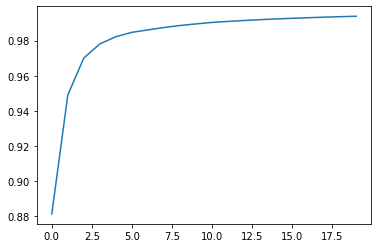

In [7]:
plt.plot(np.cumsum(s**2/sum(s**2))[:20])

In [8]:
train_data = np.array(coeffs)[:4]
scaler = MinMaxScaler((-1, 1))
train_data = scaler.fit_transform(train_data.reshape(-1, 1))\
    .reshape(train_data.shape)

In [9]:
# Create boundaries and initial values arrays for prediction later
boundaries = np.zeros((2, 10, 800))
boundaries[0] = np.dot(R.T, grids_long[0])
boundaries[1] = np.dot(R.T, grids_long[3])

init_values = np.zeros((2, 10))
init_values[0] = np.dot(R.T, grids_long[1])[:, 0]
init_values[1] = np.dot(R.T, grids_long[2])[:, 0]

boundaries = scaler.transform(boundaries.reshape(-1, 1)).reshape(boundaries.shape)

init_values = scaler.transform(init_values.reshape(-1, 1)).reshape(init_values.shape)

## Running model 

In [2]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.0005, beta_1=0.98, beta_2=0.99999)

vars_latent = 15
nPOD = 10

encoder = build_dense_encoder(
    vars_latent,
    initializer,
    info=False,
    act="elu",
    dropout=0.8,
)
decoder = build_dense_decoder(
    nPOD,
    vars_latent,
    initializer,
    act="elu",
    dropout=0.8,
)
discriminator = build_custom_discriminator(
    vars_latent, initializer, info=False
)

In [3]:
pred_adv = Predictive_adversarial(encoder, decoder, discriminator, optimizer)
pred_adv.compile(nPOD)
pred_adv.train(
    train_data,
    2000,
    batch_size=64,
    wandb_log=False,
)

NameError: name 'train_data' is not defined

In [ ]:
predicted = pred_adv.predict(boundaries, init_values, 100)

In [4]:
predicted = scaler.inverse_transform(predicted.reshape(-1, 1)).reshape(predicted.shape)

NameError: name 'scaler' is not defined

In [ ]:
plt.plot(predicted[1, :10, :150].reshape(-1, 100).T)

In [49]:
real = np.dot(R.T, grids_long[1])[:, ::5][:, 1:]

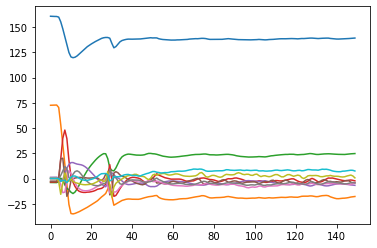

In [50]:
plt.plot(real[:10, :150].reshape(-1, 150).T)

# Latent variable prediction

## 10 latent variables

## Preprocessing and generating latent variables

In [3]:
grids = np.load("./../submodules/DD-GAN/data/processed/sf_snapshots_800steps_notrand.npy")
# Set all >0 to 0 and all <1 to 1 for alpha field
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] < 0)] = 0
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] > 1)] = 1

In [4]:
# Rescale all the velocity fields
scaler = MinMaxScaler()
grids[:,:,:,:,:3] = scaler.fit_transform(grids[:,:,:,:,:3].reshape(-1, 1)).reshape(grids[:,:,:,:,:3].shape)

In [5]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.98, beta_2=0.9)

input_shape = (60, 20, 20, 4)

encoder = keras.models.load_model("/home/zef/Documents/master/acse-9/DD-GAN-AE/submodules/DD-GAN/data/models/cae_model_different-sweep-1/encoder") 
decoder = keras.models.load_model("/home/zef/Documents/master/acse-9/DD-GAN-AE/submodules/DD-GAN/data/models/cae_model_different-sweep-1/decoder")

In [6]:
cae = CAE(encoder, decoder, optimizer)
cae.compile(input_shape)

In [7]:
latent_vars = encoder.predict(grids)

In [8]:
latent_vars.shape

(8000, 10)

In [9]:
latent_vars_reshaped = np.moveaxis(latent_vars.reshape(800, 10, 10), 0, 2)
latent_vars_reshaped.shape

(10, 10, 800)

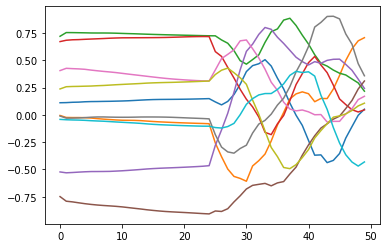

In [10]:
plt.plot(latent_vars_reshaped[1, :, :50].T)

In [12]:
# No need for transformations as these are already rescaled, grab the first four subdomains
train_data = latent_vars_reshaped

In [20]:
train_data.shape

(10, 10, 800)

In [12]:
# Create boundaries and initial values arrays for prediction later
boundaries = np.zeros((2, 10, 800))
boundaries[0] = train_data[0]
boundaries[1] = train_data[3]

init_values = np.zeros((2, 10))
init_values[0] = train_data[1][:, 0]
init_values[1] = train_data[2][:, 0]

## Running model 

In [14]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.0005, beta_1=0.98, beta_2=0.99999)

vars_latent = 30
nPOD = 10

In [15]:
encoder, decoder = build_vinicius_encoder_decoder(nPOD, vars_latent, initializer, dropout=0.6, reg=5e-5, batchnorm=False)

In [16]:
#encoder = build_dense_encoder(vars_latent,initializer,info=False,act="elu",dropout=0.8)
#decoder = build_dense_decoder(nPOD, vars_latent, initializer, act="elu",dropout=0.8)
discriminator = build_custom_discriminator(vars_latent, initializer, info=False)

In [17]:
pred_adv = Predictive_adversarial(encoder, decoder, discriminator, optimizer)
pred_adv.compile(nPOD, increment=False)
pred_adv.train(
    train_data,
    20,
    interval=5,
    val_size=0.1,
    val_batch_size=32,
    batch_size=64,
    wandb_log=False,
    noise_std=0.01
)

In [18]:
train_data[:, :, ::5][:, :, :5]

array([[[ 1.04789510e-01,  4.14403021e-01,  1.75161421e-01,
         -6.14003360e-01, -3.42585474e-01],
        [-3.08649335e-03, -5.00205755e-01,  7.09138066e-02,
          1.16214514e-01,  3.94367248e-01],
        [ 7.30427146e-01,  5.35616338e-01,  8.55275631e-01,
          3.59914899e-01,  2.50998110e-01],
        [ 6.73114300e-01,  1.45066947e-01, -1.54179156e-01,
          3.95685822e-01, -1.87263682e-01],
        [-5.30916333e-01,  4.46670532e-01,  4.10036802e-01,
          4.71653938e-01,  6.22167647e-01],
        [-7.48852909e-01, -5.83515823e-01, -6.85514808e-01,
         -3.89346212e-01, -2.01577201e-01],
        [ 4.10205156e-01,  7.16718137e-01,  2.97758996e-01,
          4.53883201e-01,  6.03930593e-01],
        [-6.75324630e-03, -2.37907395e-01,  1.77158684e-01,
          6.69756889e-01,  1.69589803e-01],
        [ 2.48113364e-01,  2.50758767e-01, -1.50310755e-01,
          1.25933349e-01,  1.37174085e-01],
        [-3.66682783e-02,  1.37079895e-01,  3.07657450e-01,
    

In [19]:
predicted = pred_adv.predict(boundaries, init_values, 40, iters=6)

NameError: name 'boundaries' is not defined

In [ ]:
plt.plot(predicted[2, :3, :40].T)

In [ ]:
train_data_int = train_data[:, :, ::5]
plt.plot(train_data_int[2, :3, :40].T)

In [26]:
mse = tf.keras.losses.MeanSquaredError()
mse(train_data_int[:4, :, :40], predicted[:, :, :40]).numpy()




0.08078625053167343

In [19]:
#out = latent_vars_reshaped[:, :, ::5][:,:,:100]
out = latent_vars_reshaped[:, :, ::10][:, :, :20]
out[1] = predicted[1, :,:20]
out[2] = predicted[2, :,:20]

In [21]:
out_reshaped = np.moveaxis(out, 2, 0).reshape(200, 10)

In [22]:
out_grids = cae.decoder.predict(out_reshaped)
out_grids[:,:,:,:,:3] = scaler.inverse_transform(out_grids[:,:,:,:,:3].reshape(-1, 1)).reshape(out_grids[:,:,:,:,:3].shape)

In [23]:
np.save("out_grids.npy", out_grids)

In [1]:
3 % 0

ZeroDivisionError: integer division or modulo by zero

## 100 latent variables

In [30]:
grids = np.load("./../submodules/DD-GAN/data/processed/sf_snapshots_800steps_notrand.npy")
# Set all >0 to 0 and all <1 to 1 for alpha field
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] < 0)] = 0
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] > 1)] = 1

In [31]:
# Rescale all the velocity fields
scaler = MinMaxScaler()
grids[:,:,:,:,:3] = scaler.fit_transform(grids[:,:,:,:,:3].reshape(-1, 1)).reshape(grids[:,:,:,:,:3].shape)

In [32]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.055, seed=None)
optimizer = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.98, beta_2=0.9)

input_shape = (60, 20, 20, 4)

encoder = keras.models.load_model("/home/zef/Documents/master/acse-9/DD-GAN-AE/submodules/DD-GAN/data/models/cae_model_woven-sweep-1/encoder") 
decoder = keras.models.load_model("/home/zef/Documents/master/acse-9/DD-GAN-AE/submodules/DD-GAN/data/models/cae_model_woven-sweep-1/decoder")

In [33]:
cae = CAE(encoder, decoder, optimizer)
cae.compile(input_shape)

In [34]:
latent_vars = cae.encoder.predict(grids)

In [35]:
latent_vars.shape

(8000, 100)

In [36]:
latent_vars_reshaped = np.moveaxis(latent_vars.reshape(800, 10, 100), 0, 2)
latent_vars_reshaped.shape

(10, 100, 800)

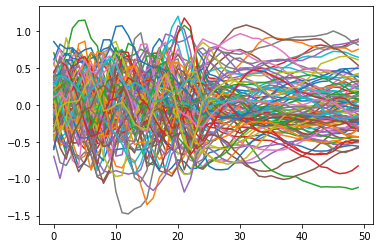

In [38]:
plt.plot(latent_vars_reshaped[0, :, :50].T)

In [39]:
# No need for transformations as these are already rescaled, grab the first four latent variables
train_data = latent_vars_reshaped[:4]

In [ ]:
# Create boundaries and initial values arrays for prediction later
boundaries = np.zeros((2, 10, 800))
boundaries[0] = train_data[0]
boundaries[1] = train_data[3]

init_values = np.zeros((2, 10))
init_values[0] = train_data[1][:, 0]
init_values[1] = train_data[2][:, 0]

In [16]:
for i in range(1):
    print(i)

0


In [18]:
grid_coeffs = np.array(train_data)[:, :, 0::1]

In [19]:
grid_coeffs.shape

(4, 10, 800)

In [36]:
x_train_full = np.array(np.arange(0, 10))
y_train_full = np.array(np.arange(10, 20))


train_dataset = tf.data.Dataset.from_tensor_slices((x_train_full,
                                                y_train_full))
train_dataset = train_dataset.shuffle(buffer_size=train_data.shape[0],
                                              reshuffle_each_iteration=True).batch(4, drop_remainder=True)

In [37]:
for (x, y) in train_dataset:
    print(x, y)

tf.Tensor([1 4 3 6], shape=(4,), dtype=int64) tf.Tensor([11 14 13 16], shape=(4,), dtype=int64)
tf.Tensor([0 8 5 9], shape=(4,), dtype=int64) tf.Tensor([10 18 15 19], shape=(4,), dtype=int64)


In [49]:
a = np.arange(0, 20)

In [52]:
train_dataset = tf.data.Dataset.from_tensor_slices(a)
train_dataset = train_dataset.\
    shuffle(buffer_size=len(a),
            reshuffle_each_iteration=True).\
    batch(3,
          drop_remainder=True)

In [53]:
add_noise = tf.keras.Sequential([GaussianNoise(0.2)])
train_dataset = train_dataset.map(lambda x: (add_noise(float(x), training=True)))

In [2]:
pred = np.load("/home/zef/Documents/master/acse-9/data/predicted_102grids_200steps.npy")
latent_decoder = keras.models.load_model("/home/zef/Documents/master/acse-9/data/cae_model_different-sweep-1/decoder")

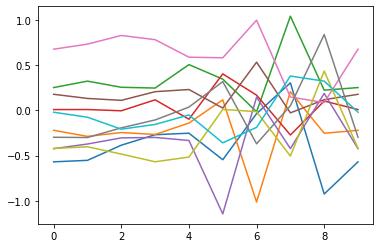

In [19]:
plt.plot(pred_first10[0, :].T)


In [16]:
pred_first10 = pred[0:1, :, 125:135]

In [17]:
pred_first10.shape

(1, 10, 10)

In [132]:
out_reshaped = np.moveaxis(pred_first10, 2, 0).reshape(500, 10)

In [133]:
out_grids = latent_decoder.predict(out_reshaped)

In [134]:
np.save("out_grids_doms0to10", out_grids)

## FPC POD Prediction

In [2]:
# Data processing
POD_coeffs = np.load("pod_coeffs_field_Velocity.npy")
train_data = POD_coeffs

In [3]:
# Scaling the latent variables
scaler = MinMaxScaler((-1, 1))
train_data = scaler.fit_transform(
  train_data.reshape(-1, 1)).reshape(train_data.shape)

In [4]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.00005, beta_1=0.98, beta_2=0.99999)

vars_latent = 30
nPOD = 10

In [5]:
encoder, decoder = build_slimmer_vinicius_encoder_decoder(
                10,
                30,
                initializer,
                act="elu",
                dense_act="linear",
                dropout=0.3,
                reg=0.00001,
                batchnorm=False,
                final_act="tanh"
            )
discriminator = build_custom_wider_discriminator(
    30, initializer, info=False
)

In [6]:
pred_adv = Predictive_adversarial(encoder, decoder, discriminator, optimizer)
pred_adv.compile(nPOD, increment=False)
pred_adv.train(
    train_data,
    20,
    interval=3,
    val_size=0.1,
    val_batch_size=32,
    batch_size=64,
    wandb_log=False,
    noise_std=0.01,
    n_discriminator=1,
    n_gradient_ascent=3
)

In [7]:
# Create boundaries and initial values arrays for prediction later
boundaries = np.zeros((2, 10, 400))
boundaries[0] = train_data[0, :, 800:1200]
boundaries[1] = train_data[3, :, 800:1200]


init_values = np.zeros((2, 10))
init_values[0] = train_data[1, :, 800]
init_values[1] = train_data[2, :, 800]

In [8]:
predicted = pred_adv.predict(boundaries, init_values, 99, iters=4, sor=1)

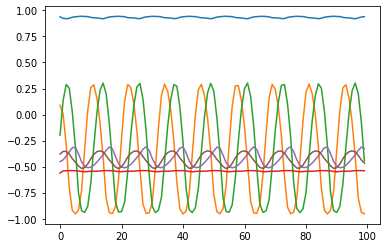

In [17]:
plt.plot(predicted[1, :6, :100].T)

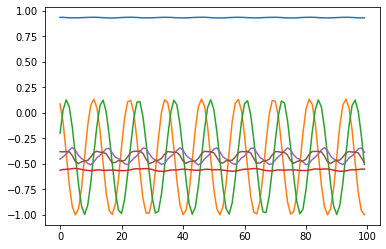

In [20]:
plt.plot(train_data[1, :6, 800:1100:3].T)